In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import torch 
from torchvision import datasets

sys.path.append('/home/tuxae/MVA/recvis21_a3')
from src import visualize_bounding_boxes

%load_ext autoreload
%autoreload 2

In [2]:
# Data initialization and loading
from src.data import data_transforms

batch_size = 32
data = "../bird_dataset"

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data + "/train_images", transform=data_transforms["train"]),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data + "/val_images", transform=data_transforms["val"]),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)

## Install Detectron 2

In [3]:
!pip install pyyaml==5.1

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

torch:  1.10 ; cuda:  cu102
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

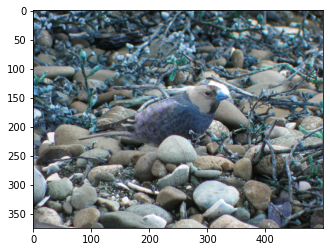

In [5]:
im = cv2.imread("../bird_dataset/train_images/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0064_27007.jpg")
plt.imshow(im)
plt.show()

## Create Detector 

In [6]:
cfg = get_cfg()
# Only CPU available 
cfg.MODEL.DEVICE="cpu"
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_HEADS.NMS = 0.4 # NMS Threshold 
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

## Predict for one image

In [7]:
# get predictions for the image
outputs = predictor(im)
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([14])
Boxes(tensor([[ 65.4200, 125.6317, 335.3425, 239.2313]]))


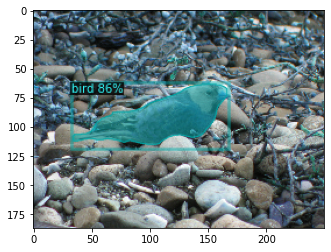

In [8]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

## Check on a list of training images

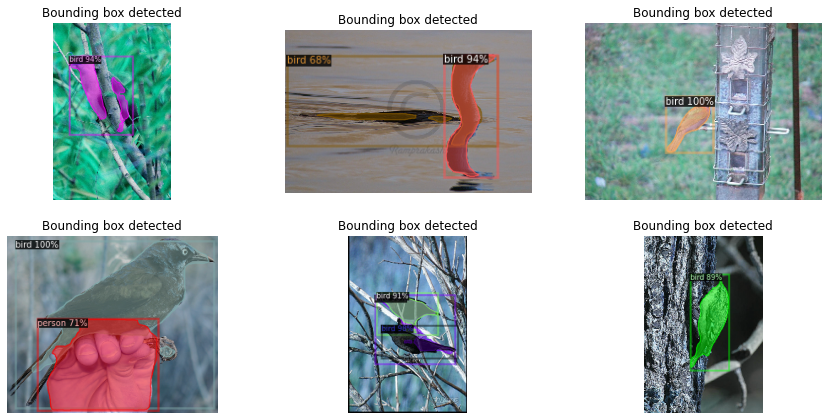

In [10]:
images_path = [
    "../bird_dataset/train_images/033.Yellow_billed_Cuckoo/Yellow_Billed_Cuckoo_0116_26544.jpg",
    "../bird_dataset/train_images/023.Brandt_Cormorant/Brandt_Cormorant_0029_23043.jpg",
    "../bird_dataset/train_images/016.Painted_Bunting/Painted_Bunting_0001_16585.jpg",
    "../bird_dataset/train_images/011.Rusty_Blackbird/Rusty_Blackbird_0031_6699.jpg",
    "../bird_dataset/train_images/011.Rusty_Blackbird/Rusty_Blackbird_0047_7009.jpg",
    "../bird_dataset/train_images/028.Brown_Creeper/Brown_Creeper_0058_24933.jpg"
]

visualize_bounding_boxes(predictor, images_path, cfg, figsize=(15,15))